In [1]:
import torch
import torchaudio
from torch import nn
from torch.nn import functional as F
from torch.utils.data import ConcatDataset
import os
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio
from IPython.display import clear_output, display
import librosa
import math
import datetime
import time
import numpy as np
import ast
import random
import shutil
import soundfile as sf
from tqdm import tqdm
from pedalboard import *

#Eigene Sachen
from util.util import *
from util.datasets import *
from util.audio_processing import *
import util.plot as plot

In [2]:
#Konstante
SAMPLE_RATE = 16000

#Lädt Noise
dir = #ADD PATH
file_dataset_background_noise_train  = LocalFileDataset(os.path.join(dir, r"NOISES RAW/SPLITTED/BACKGROUND_NOISES/TRAIN"), target_samplerate=SAMPLE_RATE)
file_dataset_foreground_noise_train = LocalFileDataset(os.path.join(dir,  r"NOISES RAW/SPLITTED/FOREGROUND_NOISES/TRAIN"), target_samplerate=SAMPLE_RATE)

speechcommands_dataset = torchaudio.datasets.SPEECHCOMMANDS(
    "/mnt/data/source_jonas/VAD/Scripte/data/samples/GENERIERUNG/SPEECH COMANDS",
    download=True
)

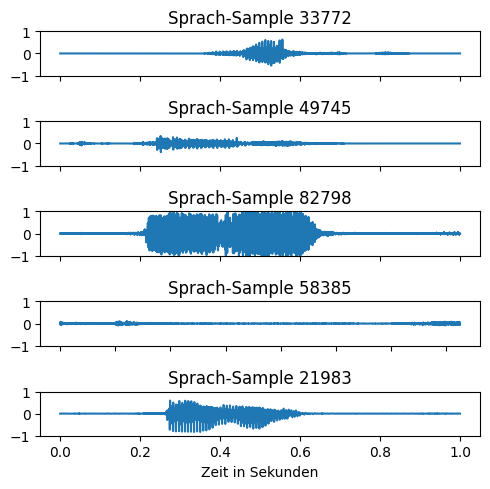

In [3]:
#Voice
_num_plots = 5

#Plot
fig = plt.figure(figsize=(5,_num_plots))

#Iterriert
for i in range(_num_plots):
    
    #Lädt random Sample
    random_idx = np.random.randint(0, len(speechcommands_dataset))
    tensor, sr, *_ = speechcommands_dataset[ random_idx ]
    tensor = tensor[0]

    #Plottet
    ax = plt.subplot2grid((_num_plots, 1), (i, 0), fig=fig)
    plot.plot_waveform(tensor, sr = sr, ax=ax, y_axis_0dbfs_scale=True)

    ax.set_title(f"Sprach-Sample {random_idx}")
    ax.set_xlabel("Zeit in Sekunden")
    ax.set_ylabel("")

#Fix Ax
for ax in fig.get_axes():
    ax.label_outer()

#Plot
fig.tight_layout()

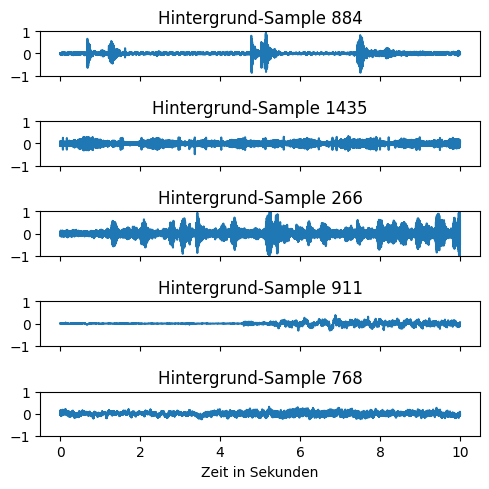

In [4]:
#Noises
_num_plots = 5

#Plot
fig = plt.figure(figsize=(5,_num_plots))

#Iterriert
for i in range(_num_plots):
    
    #Lädt random Sample
    random_idx = np.random.randint(0, len(file_dataset_background_noise_train))
    tensor, sr, _ = file_dataset_background_noise_train[ random_idx ]

    #Plottet
    ax = plt.subplot2grid((_num_plots, 1), (i, 0), fig=fig)
    plot.plot_waveform(tensor, sr = sr, ax=ax, y_axis_0dbfs_scale=True)

    ax.set_title(f"Hintergrund-Sample {random_idx}")
    ax.set_xlabel("Zeit in Sekunden")
    ax.set_ylabel("")

#Fix Ax
for ax in fig.get_axes():
    ax.label_outer()

#Plot
fig.tight_layout()

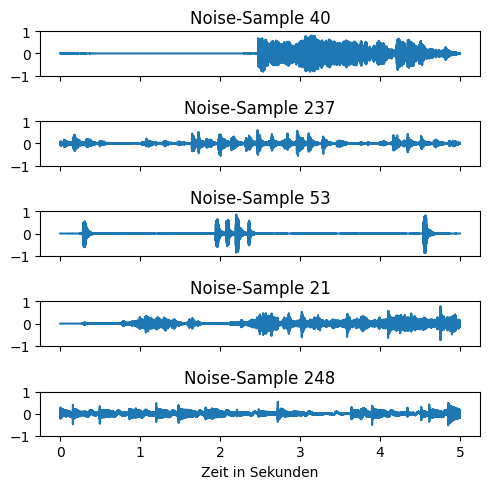

In [5]:
#Foleys
_num_plots = 5

#Plot
fig = plt.figure(figsize=(5,_num_plots))

#Iterriert
for i in range(_num_plots):
    
    #Lädt random Sample
    random_idx = np.random.randint(0, len(file_dataset_foreground_noise_train))
    tensor, sr, _ = file_dataset_foreground_noise_train[ random_idx ]

    #Plottet
    ax = plt.subplot2grid((_num_plots, 1), (i, 0), fig=fig)
    plot.plot_waveform(tensor, sr = sr, ax=ax, y_axis_0dbfs_scale=True)

    ax.set_title(f"Noise-Sample {random_idx}")
    ax.set_xlabel("Zeit in Sekunden")
    ax.set_ylabel("")

#Fix Ax
for ax in fig.get_axes():
    ax.label_outer()

#Plot
fig.tight_layout()

In [6]:
class SampleGenerator(nn.Module):
    
    def __init__(
            self,
        ):
        super().__init__()

        #Variables
        self.normalize_result = True
    
    @torch.no_grad()
    def forward(self,
            #Waveforms
            waveform, noise, waveform_ground_truth, layer_1 = None, layer_2  = None,
            
            #Params
            no_speech_to_speech_ratio = 5,
            sn_ratio_db         = 0,
            sn_ratio_db_layer_1 = 0,
            sn_ratio_db_layer_2 = 0,
            noise_edge = librosa.time_to_samples( times = 0.5, sr = SAMPLE_RATE),

            #Layer
            numb_layer_1 = 1,
            numb_layer_2 = 1,
            
            #Reverb
            reverb_room_size = None, waveform_wet = None, noise_wet = None, layer_1_wet = None, layer_2_wet = None,
        ):

        #Kalkuliert länge vom Ergebniss
        _ground_truth_non_zeros_idx   = waveform_ground_truth.nonzero().flatten()
        _length_ground_truth          = _ground_truth_non_zeros_idx.size(-1)
        _start_idx                    = _ground_truth_non_zeros_idx[0]
        _end_idx                      = _ground_truth_non_zeros_idx[-1]
        _start_end_diff               = _end_idx - _start_idx + 1 
        _length_out_tensors           = _length_ground_truth * (no_speech_to_speech_ratio + 1)

        #Falss Länge zu klein ist...
        _min_length_out_tensors = _start_end_diff + noise_edge * 2
        _length_out_tensors     = max(_length_out_tensors, _min_length_out_tensors)

        #Ergenis
        out_waveform              = torch.zeros(_length_out_tensors)
        out_waveform_ground_truth = torch.zeros(_length_out_tensors)

        #Falls Noise vohanden ist ... wird Backgroundlayer mit Noise erstellt
        if noise is not None and sn_ratio_db is not None:
            
            #Kalkuliert Startpunkt
            _noise_non_zeros_idx = noise.nonzero().flatten()
            _noise_idx           = _noise_non_zeros_idx[torch.randint(0, _noise_non_zeros_idx.size(-1), size=(1,))]
            _noise_idx_offset    = torch.remainder(torch.randint(0, out_waveform.size(-1), size=(1,)),  noise.size(-1))
            _noise_start_idx     = _noise_idx - _noise_idx_offset
            if _noise_start_idx < 0:
                _noise_start_idx += noise.size(-1)

            #Verlängert Noise
            _repeats      = ( out_waveform.size(-1) // noise.size(-1) ) + 2 #Plus 2 sorgt dafür das irgendwo im Sample angefangen und wiede aufegöhrt werden kann
            noise         = noise.repeat(_repeats)

            #Fügt Noise Output hinzu
            noise         = noise[ _noise_start_idx : _noise_start_idx + out_waveform.size(-1) ]
            
            #Reverb Noise
            if noise_wet is not None:
                noise_rever = Reverb(room_size = reverb_room_size, wet_level = noise_wet)
                noise = torch.from_numpy(noise_rever(noise.numpy(), SAMPLE_RATE))

            out_waveform  += noise

        #Reverb Voice
        if waveform_wet is not None:
            waveform_reverb = Reverb(room_size=reverb_room_size, wet_level=waveform_wet)
            waveform = torch.from_numpy(waveform_reverb(waveform.numpy(), SAMPLE_RATE))

        #Kalkuliert Skalierung für SN_RATIO
        if noise is not None and sn_ratio_db is not None:
            
            rms_noise    = rms(noise)
            rms_waveform = rms(waveform[_ground_truth_non_zeros_idx])
            sn_ratio_rms = librosa.db_to_amplitude(sn_ratio_db)
            scale        = sn_ratio_rms * rms_noise / rms_waveform
            waveform     = torch.mul(waveform, scale)
                    
        #Startposition der Groundtruth
        if out_waveform.size(-1) > _min_length_out_tensors:
            _waveform_out_ground_truth_start_idx = torch.randint(0, out_waveform.size(-1) - _min_length_out_tensors, size=(1,)) + noise_edge
        else:
            _waveform_out_ground_truth_start_idx = noise_edge

        #ANFANG
        if _start_idx > _waveform_out_ground_truth_start_idx:
            src_start_idx = _start_idx - _waveform_out_ground_truth_start_idx
            dst_start_idx = 0
        else:
            src_start_idx = 0
            dst_start_idx = _waveform_out_ground_truth_start_idx - _start_idx
        
        #ENDE
        if out_waveform[dst_start_idx:].size(-1) > waveform[src_start_idx:].size(-1):
            src_end_idx = waveform.size(-1)
            dst_end_idx = dst_start_idx + waveform[src_start_idx:].size(-1)
        else:
            src_end_idx = src_start_idx + out_waveform[dst_start_idx:].size(-1)
            dst_end_idx = out_waveform.size(-1)
        
        #Start End
        waveform_start_end              = waveform [src_start_idx : src_end_idx]
        waveform_ground_truth_start_end = waveform_ground_truth[src_start_idx : src_end_idx]

        #Layer 1
        if layer_1 is not None and sn_ratio_db_layer_1 is not None:
            total_layer_1 = torch.zeros_like(out_waveform)
            
            #Iterriert Samples
            for i in range(numb_layer_1):
                
                #Kopiert Layer
                curr_layer = torch.clone(layer_1)
                
                #Hängt Länge an
                if curr_layer.size(-1) < out_waveform.size(-1):
                    padding = torch.zeros(size = (out_waveform.size(-1) - curr_layer.size(-1),) )
                    curr_layer = torch.concat([curr_layer, padding])
                
                curr_layer = curr_layer.roll( shifts = torch.randint(low=0, high=curr_layer.size(-1), size=(1,)).item() )
                curr_layer = curr_layer[ : out_waveform.size(-1) ]

                #Fügt Layer an
                total_layer_1 += curr_layer

            #Reverb
            if layer_1_wet is not None:
                layer_1_reverb = Reverb( room_size = reverb_room_size, wet_level = layer_1_wet )
                total_layer_1  = torch.from_numpy(layer_1_reverb(total_layer_1.numpy(), SAMPLE_RATE))
            
            #Fügt hinzu
            out_waveform += normalize_waveform_to_peak(total_layer_1, peak = db(waveform_start_end.abs().max()) - sn_ratio_db_layer_1)
        
        #Layer 2
        if layer_2 is not None and sn_ratio_db_layer_2 is not None:
            total_layer_2 = torch.zeros_like(out_waveform)
            
            #Iterriert Samples
            for i in range(numb_layer_2):
                
                #Kopiert Layer
                curr_layer = torch.clone(layer_2)
                
                #Hängt Länge an
                if curr_layer.size(-1) < out_waveform.size(-1):
                    padding = torch.zeros(size = (out_waveform.size(-1) - curr_layer.size(-1),) )
                    curr_layer = torch.concat([curr_layer, padding])
                
                curr_layer = curr_layer.roll( shifts = torch.randint(low=0, high=curr_layer.size(-1), size=(1,)).item() )
                curr_layer = curr_layer[ : out_waveform.size(-1) ]

                #Fügt Layer an
                total_layer_2 += curr_layer

            #Reverb
            if layer_2_wet is not None:
                layer_2_reverb = Reverb( room_size = reverb_room_size, wet_level = layer_2_wet )
                total_layer_2  = torch.from_numpy(layer_2_reverb(total_layer_2.numpy(), SAMPLE_RATE))
            
            #Fügt hinzu
            out_waveform += normalize_waveform_to_peak(total_layer_2, peak = db(waveform_start_end.abs().max()) - sn_ratio_db_layer_2)
            

        #Kopiert Waveform
        out_waveform             [dst_start_idx : dst_end_idx] += waveform_start_end
        out_waveform_ground_truth[dst_start_idx : dst_end_idx] =  waveform_ground_truth_start_end

        #Normalisiert Ergebnis
        if self.normalize_result:
            out_waveform = normalize_waveform_to_peak(out_waveform)

        return out_waveform, out_waveform_ground_truth
        

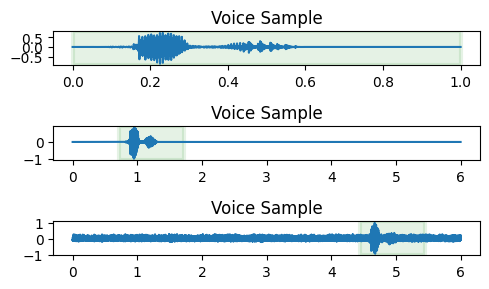

In [7]:
#Lädt Voice
voice, sr, *_ = speechcommands_dataset[8]
voice         = voice[0]
ground_truth    = torch.ones_like(voice)

#Lädt Noise
noise, sr, _    = file_dataset_background_noise_train[1]

#SampleGenerator
sg = SampleGenerator()
x_1, y_1 = sg(voice, None,  ground_truth)
x_2, y_2 = sg(voice, noise, ground_truth)

#Plot
fig = plt.figure(figsize=(5, 3))

#Voice
ax = plt.subplot2grid((3, 1), (0, 0), fig=fig)
plot.plot_waveform_with_voice(voice, ground_truth, sr = SAMPLE_RATE, ax=ax)
ax.set_title(f"Voice Sample")
ax.set_xlabel("")
ax.set_ylabel("")

ax = plt.subplot2grid((3, 1), (1, 0), fig=fig)
plot.plot_waveform_with_voice(x_1, y_1, sr = SAMPLE_RATE, ax=ax)
ax.set_title(f"Voice Sample")
ax.set_xlabel("")
ax.set_ylabel("")

ax = plt.subplot2grid((3, 1), (2, 0), fig=fig)
plot.plot_waveform_with_voice(x_2, y_2, sr = SAMPLE_RATE, ax=ax)
ax.set_title(f"Voice Sample")
ax.set_xlabel("")
ax.set_ylabel("")

#Layout
fig.tight_layout()

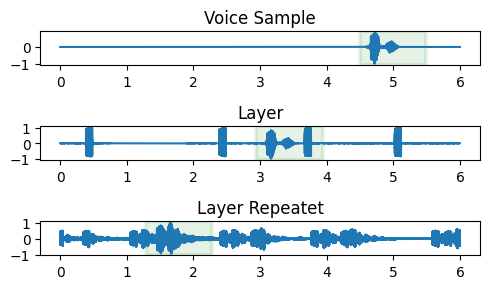

In [8]:
#Lädt Voice
voice, sr, *_ = speechcommands_dataset[8]
voice         = voice[0]
ground_truth  = torch.ones_like(voice)

#Lädt Layer
layer, sr, _ = file_dataset_foreground_noise_train[83]

#SampleGenerator
sg = SampleGenerator()
x,   y    = sg(voice, None,  ground_truth)
x_2, y_2  = sg(voice, None,  ground_truth, layer_1 = layer, sn_ratio_db_layer_1 = 0, numb_layer_1 = 1)
x_3, y_3  = sg(voice, None,  ground_truth,
    layer_2 = layer, sn_ratio_db_layer_2 = 0, numb_layer_2 = 4,
    reverb_room_size = 0.7, layer_2_wet = 0.5, waveform_wet = 0.2
)

#Plot
fig = plt.figure(figsize=(5, 3))

#Normal
ax = plt.subplot2grid((3, 1), (0, 0), fig=fig)
plot.plot_waveform_with_voice(x, y, sr = SAMPLE_RATE, ax=ax)
ax.set_title(f"Voice Sample")
ax.set_xlabel("")
ax.set_ylabel("")

ax = plt.subplot2grid((3, 1), (1, 0), fig=fig)
plot.plot_waveform_with_voice(x_2, y_2, sr = SAMPLE_RATE, ax=ax)
ax.set_title(f"Layer")
ax.set_xlabel("")
ax.set_ylabel("")

ax = plt.subplot2grid((3, 1), (2, 0), fig=fig)
plot.plot_waveform_with_voice(x_3, y_3, sr = SAMPLE_RATE, ax=ax)
ax.set_title(f"Layer Repeatet")
ax.set_xlabel("")
ax.set_ylabel("")

#Layout
fig.tight_layout()

In [9]:
#Checkt ob Waveform Inhalt hat
def check_signal_for_content(waveform = None):
    
    #Bedingungen
    check_for_gt0 = waveform.abs().max() < 1e-6
    check_for_inf = bool(torch.sum(torch.isinf(waveform)))
    check_for_nan = bool(torch.sum(torch.isnan(waveform)))
    
    #Raise Exception
    if check_for_gt0 or check_for_inf or check_for_nan:
        return False
    
    #Returnt True
    return True

In [10]:
#Layered Voice mit Noise
class SpeakDataset(Dataset):
    def __init__(self,  voice_dataset, background_noise_dataset, foreground_noise_dataset) -> None:
        super().__init__()
        
        #Switcht für Noise und Reverb
        self.add_noise   = True
        self.add_layer_1 = True
        self.add_layer_2 = True
        self.add_reverb  = True

        #Datasets
        self.voice_dataset            = voice_dataset
        self.background_noise_dataset = background_noise_dataset
        self.foreground_noise_dataset = foreground_noise_dataset

        #SampleGenerator
        self.sample_generator = SampleGenerator()

        #SN-Ratios
        self.sample_generator_sn_ratios = [None,  0,  3,  5,  6,  9, 10, 12, 18, 24]
        self.layer_1_ratios             = [None, None, 0,  3,  6,  9, 12, 18]
        self.layer_2_ratios             = [None, None, 0,  3,  6,  9, 12, 18]

        #Distortion
        self.distortion_gains    = [6, 12]
        self.distortion_dry_wets = [0.1, 0.25, 0.40]
    
    def __len__(self):
            return len(self.voice_dataset)

    @torch.no_grad()
    def __getitem__(self, voice_idx):
        
        #Reverb
        reverb_room_size = None
        waveform_wet     = None
        noise_wet        = None
        layer_1_wet      = None
        layer_2_wet      = None

        #Samples
        voice   = None
        noise   = None
        layer_1 = None
        layer_2 = None
        
        #Info
        voice_info   = None
        noise_info   = None
        layer_1_info = None
        layer_2_info = None

        #SN Ratios
        sn_ratio_db_sample         = random.choice(self.sample_generator_sn_ratios)
        sn_ratio_db_layer_1_ratio  = random.choice(self.layer_1_ratios)
        sn_ratio_db_layer_2_ratio  = random.choice(self.layer_2_ratios)

        #Lädt Samples
        voice, sr, *_ = self.voice_dataset[voice_idx]
        voice = voice[0]
        
        #Erzeugt voice_ground_truth
        voice_ground_truth = torch.ones_like(voice)
        
        if not check_signal_for_content (voice):
            raise Exception(f"VOICE-Sample {voice_idx} ist fehlerhaft")
                
        #Generiert Noise
        if self.add_noise:
            idx                  = np.random.randint(0, len(self.background_noise_dataset)) 
            noise, _, noise_info = self.background_noise_dataset[idx]
            if not check_signal_for_content (noise):
                raise Exception(f"NOISE-Sample {idx} ist fehlerhaft")
        
        if self.add_layer_1 and sn_ratio_db_layer_1_ratio is not None:
            idx                      = np.random.randint(0, len(self.foreground_noise_dataset)) 
            layer_1, _, layer_1_info = self.foreground_noise_dataset[idx]
            if not check_signal_for_content (layer_1):
                raise Exception(f"NOISE-Sample {idx} ist fehlerhaft")
        
        if self.add_layer_2 and sn_ratio_db_layer_2_ratio is not None:
            idx                      = np.random.randint(0, len(self.foreground_noise_dataset)) 
            layer_2, _, layer_2_info = self.foreground_noise_dataset[idx]
            if not check_signal_for_content (layer_2):
                raise Exception(f"NOISE-Sample {idx} ist fehlerhaft")

        #Reverb
        if self.add_reverb:
            reverb_room_size = np.around(np.random.uniform(0.1,   1), decimals=2)
            waveform_wet     = np.around(np.random.uniform(0.1, 0.4), decimals=2) #0.4 entspricht 50% dry/wet
            layer_1_wet      = np.around(np.random.uniform(0.1, 0.4), decimals=2) #0.4 entspricht 50% dry/wet
            layer_2_wet      = np.around(layer_1_wet  + np.random.uniform(0.05, 0.3), decimals=2) #0.4 entspricht 50% dry/wet
            noise_wet        = np.around(waveform_wet + np.random.uniform(0.05, 0.3), decimals=2)

        #Layert Sample mit Noise
        waveform, voice_ground_truth = self.sample_generator(
            
            #Wavforms
            waveform = voice, noise = noise, waveform_ground_truth = voice_ground_truth,
            layer_1 = layer_1, layer_2  = layer_2,
            
            #SN
            sn_ratio_db         = sn_ratio_db_sample,
            sn_ratio_db_layer_1 = sn_ratio_db_layer_1_ratio,
            sn_ratio_db_layer_2 = sn_ratio_db_layer_2_ratio,
            
            #Reverb
            reverb_room_size = reverb_room_size,
            waveform_wet     = waveform_wet,
            noise_wet        = noise_wet,
            layer_1_wet      = layer_1_wet,
            layer_2_wet      = layer_2_wet
        )

        #Distortion
        distortion_gain    = random.choice(self.distortion_gains)
        distortion_dry_wet = random.choice(self.distortion_dry_wets)
        distorded_waveform =torch.tanh(waveform * librosa.db_to_amplitude(distortion_gain))
        waveform = ( waveform * (1 - distortion_dry_wet) ) + ( distorded_waveform * distortion_dry_wet )

        #Checkt Output
        if not (check_signal_for_content (waveform) and check_signal_for_content(voice_ground_truth)):
            raise Exception(f"Ergebnis hat Probleme")

        #Returnt Sample
        return waveform, voice_ground_truth, {
            "sn_ratio_db_sample"        : sn_ratio_db_sample,
            "sn_ratio_db_layer_1_ratio" : sn_ratio_db_layer_1_ratio,
            "sn_ratio_db_layer_2_ratio" : sn_ratio_db_layer_2_ratio,
            "reverb_room_size" : reverb_room_size,
            "waveform_wet"     : waveform_wet,
            "noise_wet"        : noise_wet,
            "layer_1_wet"      : layer_1_wet,
            "layer_2_wet"      : layer_2_wet,
            "distortion_gain"    : distortion_gain,
            "distortion_dry_wet" : distortion_dry_wet,
            "voice_info"   : voice_info.to_dict()   if voice_info is not None else None,
            "noise_info"   : noise_info.to_dict()   if noise_info is not None else None,
            "layer_1_info" : layer_1_info.to_dict() if layer_1_info is not None else None,
            "layer_2_info" : layer_2_info.to_dict() if layer_2_info is not None else None,
        }

In [11]:
#SpeakDataset
speak_dataset = SpeakDataset(speechcommands_dataset, file_dataset_background_noise_train, file_dataset_foreground_noise_train)

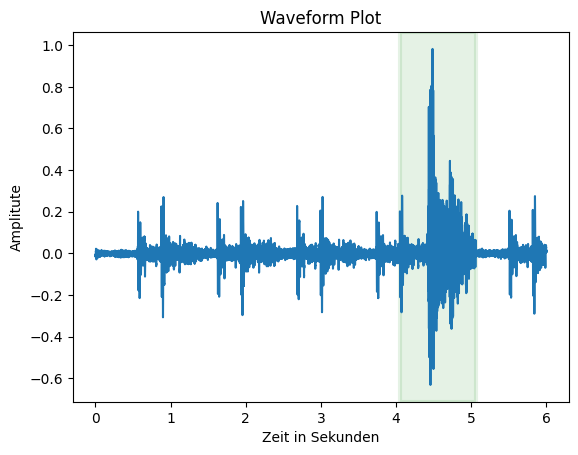

In [12]:
x, y, info = speak_dataset[501]
plot.plot_waveform_with_voice(x,y, sr=SAMPLE_RATE)
Audio(data=x,rate=SAMPLE_RATE)

In [13]:
#SAVE CSV
EXPORT_EVERY_SAMPLES = 1000

#PARAMETER
dataset        = speak_dataset
out_per_sample = 4
out_path       = #ADD PATH
csv_path       = #ADD PATH

#PARAMETER
#dataset        = speak_dataset_train
#out_per_sample = 5
#out_path       = r"/mnt/data/source_jonas/VAD/Scripte/data/samples/DATA/TRAIN"
#csv_path       = r"/mnt/data/source_jonas/VAD/Scripte/data/samples/DATA/train.csv"

#Löscht Pfad
if os.path.exists(out_path):
    shutil.rmtree(out_path)

#Löscht CSV
if os.path.exists(csv_path):
    os.remove(csv_path)

#Erstellt Pfad
os.mkdir(out_path)

#Ergebnis
result = []

#Iterriert über Dataset
for idx in tqdm( range(len(dataset)) ):
    
    #Iterriert Anzahl der Samples für Out
    for run in range(out_per_sample):
        
        #Lädt Sample
        x, y, info = dataset[idx]

        #Erzeugt Name
        filename = f"{idx}_{run}.wav"

        #Out
        sf.write(file = os.path.join(out_path,filename), data = x, samplerate=SAMPLE_RATE)

        #Y
        nonzero = y.nonzero().flatten()
        start = nonzero.min().item()
        end   = nonzero.max().item()

        #Fügt Zeile an
        result.append({
            "filename" : filename,
            "start"    : start,
            "end"      : end,
            "info"     : info
        })

    #Export aller 100 Samples
    if idx % EXPORT_EVERY_SAMPLES == 0:
        pd.DataFrame(result).to_csv(csv_path, index=False)

#Ergebnis -> csv
pd.DataFrame(result).to_csv(csv_path, index=False)

100%|██████████| 87755/87755 [54:09<00:00, 27.01it/s]  
